In [1]:
import pandas as pd
data = pd.read_csv('data/new_product_info3.csv')

Training new word2vec

In [80]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

ings = pd.read_csv('data/ingredients_dataset.csv')

# Convert all values in 'ingredient' column to strings
ings['ingredient'] = ings['ingredient'].astype(str)

# Tokenize the ingredients
ings['tokenized_ingredients'] = ings['ingredient'].apply(simple_preprocess)

# Train Word2Vec on the tokenized ingredients
word2vec_model = Word2Vec(
    sentences=ings['tokenized_ingredients'],
    vector_size=100,       # Dimensionality of the embeddings
    window=5,              # Context window size
    min_count=1,           # Include all ingredients, even rare ones
    workers=4,             # Use 4 CPU cores for training
    sg=1,                  # Use Skip-Gram model
    epochs=10              # Number of iterations over the corpus
)

In [2]:
# Save the model
word2vec_model.save("data/model/ingredient_word2vec.model")

NameError: name 'word2vec_model' is not defined

In [2]:
from gensim.models import Word2Vec

# Load the trained Word2Vec model
word2vec_model = Word2Vec.load("data/model/ingredient_word2vec.model")

In [4]:
import numpy as np

def get_sentence_vector(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Take the average of word vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words match

In [81]:
# Generate embeddings for each product's ingredients
data['ingredient_embeddings'] = data['tokenized_ingredients'].apply(
    lambda x: get_sentence_vector(word2vec_model, x)
)

Cross Validation

In [82]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Extract features (ingredient embeddings) and labels (primary category)
X = np.vstack(data['ingredient_embeddings'])
y = data['primary_category']

# Try different K values
k_values = [3, 5, 10, 15]
scores = {}

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = RandomForestClassifier(random_state=42)

    # Perform Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    scores[k] = np.mean(cv_scores)

# Find the best K
best_k = max(scores, key=scores.get)
best_accuracy = scores[best_k]

print(f"Best K: {best_k} with Accuracy: {best_accuracy:.4f}")

# Train the final model using the best K
final_skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
final_model = RandomForestClassifier(random_state=42)

# Perform final training
final_model.fit(X, y)

print("Final model trained with K =", best_k)

Best K: 15 with Accuracy: 0.7943
Final model trained with K = 15


In [45]:
classifier = final_model

In [96]:
import joblib

classifier = final_model

# Save the model to a file
joblib.dump(final_model, "data/model/new_random_forest.pkl")

['data/model/new_random_forest.pkl']

In [3]:
import joblib

# Load the saved model
final_model = joblib.load("data/model/new_random_forest.pkl")

classifier = final_model

In [40]:
from gensim.utils import simple_preprocess
import numpy as np

def get_sentence_vector(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Take the average of word vectors
    else:
        return np.zeros(model.vector_size)

# Example ingredient list for prediction
new_ingredients = r"Alcohol Denat, Butyl Methoxydibenzoylmethane, Aqua (Water), Limonene,Parfum (Fragrance), Hydroxycitronellal, Citronellol, Linalool, Coumarin, Alpha-Isomethyl Ionone, Alcohol, Citral, Tris(Tetramethylhydroxypiperidinol) Citrate, Geraniol, Benzyl Benzoate, Farnesol, Isoeugenol, Ci 17200 (Red 33),Ci 19140 (Yellow 5)."

# Tokenize and generate embeddings
new_tokens = simple_preprocess(new_ingredients)
new_embedding = get_sentence_vector(word2vec_model, new_tokens).reshape(1, -1)

# Compute embeddings individually
input_embedding = new_embedding

# Predict the category
predicted_category = classifier.predict(new_embedding)
print("Predicted Primary Category:", predicted_category[0])

Predicted Primary Category: Fragrance


### Just Recommending

In [42]:
import json
import torch
import numpy as np
import pandas as pd
import re
from torch.nn.functional import cosine_similarity
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Function to normalize ingredient names
def normalize_ingredient(ingredient):
    if not isinstance(ingredient, str):
        ingredient = str(ingredient)
    ingredient = ingredient.lower()  # Convert to lowercase
    ingredient = re.sub(r'[-.,/]+', ' ', ingredient)  # Replace separators with space
    ingredient = re.sub(r'\s+', ' ', ingredient).strip()  # Remove extra spaces
    return ingredient

def split_and_normalize_ingredients(ingredients_list):
    all_ingredients = []
    if isinstance(ingredients_list, str):
        ingredients_list = [ingredients_list]

    for ingredients_str in ingredients_list:
        if not isinstance(ingredients_str, str):
            continue
        # Split by commas while preserving items with parentheses
        ingredients = re.split(r',\s*(?![^()]*\))', ingredients_str)
        # Normalize each ingredient
        normalized_ingredients = [normalize_ingredient(ingredient) for ingredient in ingredients]
        all_ingredients.extend(normalized_ingredients)
    return all_ingredients

def get_sentence_vector(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Take the average of word vectors
    else:
        return np.zeros(model.vector_size)

# Example ingredient list for prediction
new_ingredients = r"Alcohol Denat, Butyl Methoxydibenzoylmethane, Aqua (Water), Limonene,Parfum (Fragrance), Hydroxycitronellal, Citronellol, Linalool, Coumarin, Alpha-Isomethyl Ionone, Alcohol, Citral, Tris(Tetramethylhydroxypiperidinol) Citrate, Geraniol, Benzyl Benzoate, Farnesol, Isoeugenol, Ci 17200 (Red 33),Ci 19140 (Yellow 5)."

# Load concern chemicals, red list, and allergens lists
concern_chems = []
red_list = []
the_gens = []  # allergens

try:
    with open("data/concern_chems.txt") as f:
        concern_chems = [normalize_ingredient(line.strip()) for line in f]
except FileNotFoundError:
    print("Warning: concern_chems.txt not found. Using empty list.")

try:
    with open("data/red_list.txt") as f:
        red_list = [normalize_ingredient(line.strip()) for line in f]
except FileNotFoundError:
    print("Warning: red_list.txt not found. Using empty list.")

try:
    with open("data/the_gens.txt") as f:
        the_gens = [normalize_ingredient(line.strip()) for line in f]
except FileNotFoundError:
    print("Warning: the_gens.txt not found. Using empty list.")

# Convert the input ingredient list into normalized items
normalized_input_ingredients = split_and_normalize_ingredients([new_ingredients])

# Convert the input ingredient list into normalized items
input_ingredients1 = split_and_normalize_ingredients([new_ingredients])


# Identify which ingredients match red list, the gens (allergens), and concern chems
red_list_include = []
for i in normalized_input_ingredients:
    for j in red_list:
        if i == j:
            red_list_include.append(j)

the_gens_include = []  # allergens detected in input
for i in normalized_input_ingredients:
    for j in the_gens:
        if i == j:
            # Avoid duplicates
            if j not in red_list_include:
                the_gens_include.append(j)

concern_chems_include = []
for i in normalized_input_ingredients:
    for j in concern_chems:
        if i == j:
            if j not in red_list_include and j not in the_gens_include:
                concern_chems_include.append(j)

print("Input Ingredient Analysis:")
print("Matched Red List Ingredients:", red_list_include)
print("Matched Average Risk (Allergens):", the_gens_include)
print("Matched Low Risk (Emerging Concern):", concern_chems_include)

# Tokenize and generate embeddings
new_tokens = simple_preprocess(new_ingredients)
new_embedding = get_sentence_vector(word2vec_model, new_tokens).reshape(1, -1)

# Compute embeddings individually
input_embedding = new_embedding

Input Ingredient Analysis:
Matched Red List Ingredients: ['isoeugenol']
Matched Average Risk (Allergens): ['limonene', 'linalool', 'coumarin', 'citral', 'geraniol', 'benzyl benzoate', 'farnesol']
Matched Low Risk (Emerging Concern): []


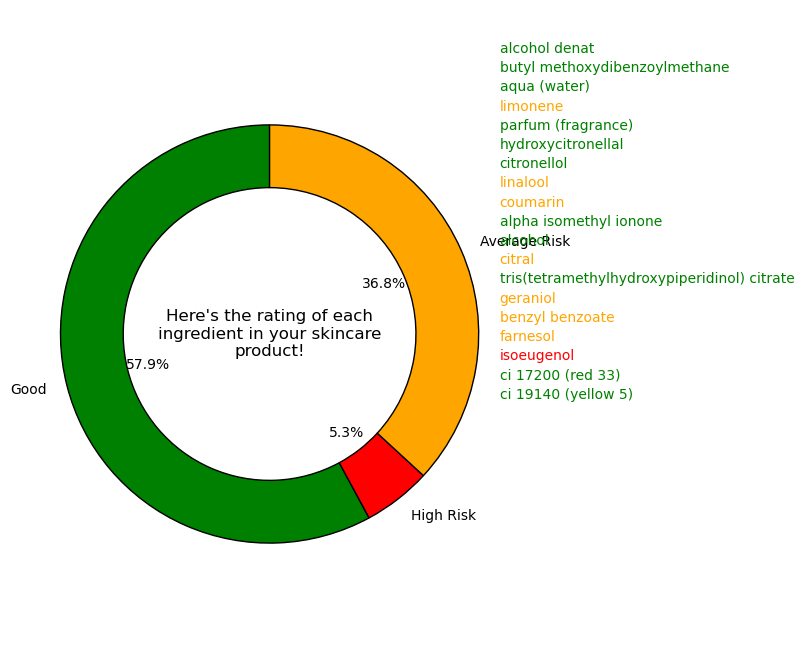

In [43]:
# Calculate counts for visualization
high_risk_count = len(red_list_include)
average_risk_count = len(the_gens_include)
low_risk_count = len(concern_chems_include)
# Using normalized_input_ingredients instead of input_ingredients1
good_count = len(normalized_input_ingredients) - high_risk_count - average_risk_count - low_risk_count

# Filter out zero-value categories
# IMPORTANT: Changed variable name from 'data' to 'chart_data' to avoid conflict with DataFrame
chart_data = []  # Changed from 'data' to 'chart_data'
labels = []
colors = []

if good_count > 0:
    chart_data.append(good_count)
    labels.append('Good')
    colors.append('green')
if high_risk_count > 0:
    chart_data.append(high_risk_count)
    labels.append('High Risk')
    colors.append('red')
if average_risk_count > 0:
    chart_data.append(average_risk_count)
    labels.append('Average Risk')
    colors.append('orange')
if low_risk_count > 0:
    chart_data.append(low_risk_count)
    labels.append('Low Risk')
    colors.append('yellow')

# Visualization using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Donut chart parameters
wedgeprops = {'width': 0.3, 'edgecolor': 'black'}  # Adjust width for hole size
center_circle = Circle((0, 0), 0.4, color='white')  # Circle in the center
ax.add_artist(center_circle)

# Create the pie chart (with the "donut" hole)
if chart_data:  # Use chart_data instead of data
    wedges, texts, autotexts = ax.pie(chart_data, autopct='%1.1f%%', startangle=90,
                                      colors=colors, labels=labels, wedgeprops=wedgeprops,
                                      textprops={'color': 'black'})

    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')

    # Add title inside the donut hole
    ax.text(0, 0, "Here's the rating of each\ningredient in your skincare\nproduct!", ha='center', va='center', fontsize=12, color='black')

    # Use normalized_input_ingredients instead of input_ingredients1
    ingredients_list = normalized_input_ingredients

    # Add ingredient list (right side) if there are ingredients to display
    if ingredients_list:
        fig.subplots_adjust(right=0.7)  # Adjust right margin for ingredient list
        ax2 = fig.add_axes([0.7, 0.1, 0.25, 0.8])  # left, bottom, width, height
        ax2.axis('off')  # hide axis

        # Combine ingredients for display with correct colors
        ingredients_to_display = []
        for ing in ingredients_list:  # Use ingredients_list instead of input_ingredients1
            if ing in red_list_include:
                ingredients_to_display.append((ing, 'red'))
            elif ing in the_gens_include:
                ingredients_to_display.append((ing, 'orange'))
            elif ing in concern_chems_include:
                ingredients_to_display.append((ing, 'yellow'))
            else:
                ingredients_to_display.append((ing, 'green'))

        # Display ingredients with color coding
        y_pos = 0.95
        for ing, color in ingredients_to_display:
            ax2.text(0, y_pos, ing, color=color, fontsize=10, va='top')
            y_pos -= 0.03  # Adjust spacing as needed

    # Display the plot instead of saving it
    plt.show()

In [37]:
# Predict the category
predicted_category = classifier.predict(new_embedding)
print("Predicted Primary Category:", predicted_category[0])

def compute_similarity(input_emb, product_emb):
    """Compute cosine similarity between two embeddings"""
    try:
        # Convert numpy arrays to tensors
        if isinstance(input_emb, np.ndarray):
            input_emb = torch.tensor(input_emb, dtype=torch.float32)
        if isinstance(product_emb, np.ndarray):
            product_emb = torch.tensor(product_emb, dtype=torch.float32)
        # Ensure 1D by flattening if needed
        if len(input_emb.shape) > 1:
            input_emb = input_emb.flatten()
        if len(product_emb.shape) > 1:
            product_emb = product_emb.flatten()
        # Match dimensions if different lengths
        if input_emb.shape[0] != product_emb.shape[0]:
            min_len = min(input_emb.shape[0], product_emb.shape[0])
            input_emb = input_emb[:min_len]
            product_emb = product_emb[:min_len]
        return cosine_similarity(input_emb.unsqueeze(0), product_emb.unsqueeze(0)).item()
    except Exception:
        return 0.0

# If input_embedding is 2D (with shape of (1,n)), flatten to 1D
if isinstance(input_embedding, np.ndarray) and len(input_embedding.shape) > 1 and input_embedding.shape[0] == 1:
    input_embedding = input_embedding.flatten()

def process_embeddings(dataset):
    """Process embedding columns in the dataset."""
    emb_columns = [
        "ingredients_embedding",
        "concern_chems_embedding",
        "red_list_embedding",
        "the_gens_embedding"
    ]
    for col in emb_columns:
        if col in dataset.columns:
            def convert_embedding(x):
                if isinstance(x, np.ndarray):
                    return x
                if x is None:
                    return np.zeros(100)
                try:
                    if pd.isna(x):
                        return np.zeros(100)
                except:
                    pass
                if isinstance(x, str):
                    try:
                        return np.array(json.loads(x))
                    except Exception:
                        return np.zeros(100)
                try:
                    return np.array(x)
                except Exception:
                    return np.zeros(100)
            dataset[col] = dataset[col].apply(convert_embedding)
    return dataset

# Process the dataset
data = process_embeddings(data)

# Function to safely process ingredient lists
def safe_process_ingredients(item):
    """Safely process ingredient lists avoiding pd.isna() issues"""
    # Handle None values
    if item is None:
        return []

    # Check if it's already a list
    if isinstance(item, list):
        # Process each element to handle potential nested lists
        result = []
        for elem in item:
            if isinstance(elem, str):
                # Check if the string looks like a list representation
                if elem.strip().startswith('[') and elem.strip().endswith(']'):
                    try:
                        # Try different parsing methods
                        try:
                            # First try JSON parsing with proper quote replacement
                            parsed = json.loads(elem.replace("'", '"'))
                            if isinstance(parsed, list):
                                result.extend(parsed)
                            else:
                                result.append(parsed)
                        except:
                            # Then try ast.literal_eval
                            import ast
                            try:
                                parsed = ast.literal_eval(elem)
                                if isinstance(parsed, list):
                                    result.extend(parsed)
                                else:
                                    result.append(parsed)
                            except:
                                # If all parsing fails, keep the original string
                                result.append(elem)
                    except:
                        result.append(elem)
                else:
                    # Not a list representation, keep as is
                    result.append(elem)
            elif isinstance(elem, list):
                # Flatten nested lists
                result.extend(elem)
            else:
                # Keep other types as is
                result.append(elem)
        return result

    # Handle string values
    if isinstance(item, str):
        if not item or item == '[]':
            return []

        # Check if it's a JSON-like string representation of a list
        if item.strip().startswith('[') and item.strip().endswith(']'):
            try:
                # Try to parse as JSON with proper quote replacement
                parsed = json.loads(item.replace("'", '"'))
                if isinstance(parsed, list):
                    return parsed
                return [parsed]
            except:
                # Try with ast.literal_eval if JSON parsing fails
                try:
                    import ast
                    parsed = ast.literal_eval(item)
                    if isinstance(parsed, list):
                        return parsed
                    return [parsed]
                except:
                    # If all parsing fails, treat as a single item
                    return [item]

        # Handle comma-separated strings
        if ',' in item:
            return [x.strip() for x in item.split(',')]

        # Single value string
        return [item]

    # For any other type, try to convert to a list or return empty list
    try:
        return list(item)
    except:
        return []

# Initialize and process the ingredient columns
for col in ["concerning_chems_detected", "red_list_chems_detected", "allergens_detected"]:
    if col not in data.columns:
        data[col] = [[] for _ in range(len(data))]
    else:
        # Apply the safe processing function
        data[col] = data[col].apply(safe_process_ingredients)

# Mapping of primary to tertiary categories
tertiary_categories_map = {
    "Skincare": [
        "Anti-Aging", "BB & CC Cream", "Blemish & Acne Treatments", "Body Sunscreen",
        "Exfoliators", "Eye Creams & Treatments", "Eye Masks", "Face Masks",
        "Face Oils", "Face Serums", "Face Sunscreen", "Face Wash & Cleansers",
        "Facial Peels", "For Body", "For Face", "Mists & Essences",
        "Moisturizers", "Night Creams", "Sheet Masks", "Toners"
    ],
    "Makeup": [
        "Blush", "Bronzer", "Cheek Palettes", "Color Correct",
        "Concealer", "Contour", "Eye Palettes", "Eye Primer",
        "Eye Sets", "Eyebrow", "Eyeliner", "Eyeshadow",
        "Face Primer", "Face Sets", "False Eyelashes", "Foundation",
        "Highlighter", "Lip Balm & Treatment", "Lip Gloss", "Lip Liner",
        "Lip Plumper", "Lip Sets", "Lipstick", "Liquid Lipstick",
        "Makeup Removers", "Mascara", "Setting Spray & Powder", "Tinted Moisturizer"
    ],
    "Hair": [
        "Conditioner", "Dry Shampoo", "Hair Masks", "Hair Oil",
        "Hair Primers", "Hair Spray", "Hair Styling Products",
        "Leave-In Conditioner", "Scalp Treatments", "Shampoo"
    ],
    "Fragrance": [
        "Body Mist & Hair Mist", "Cologne", "Perfume", "Rollerballs & Travel Size"
    ]
}

# Use the predicted category from the classifier
primary_category = predicted_category[0]

if primary_category == "Other" or primary_category not in tertiary_categories_map:
    print("No recommendations available for this category.")
else:
    print(f"Predicted Primary Category: {primary_category}")
    print("\nAvailable Tertiary Categories:")
    available_tertiary = tertiary_categories_map.get(primary_category, [])
    for i, cat in enumerate(available_tertiary, 1):
        print(f"{i}. {cat}")
    print("\nPlease enter the numbers of tertiary categories you're interested in (comma-separated).")
    print("Example: 1,4,7")
    user_input = input("Enter your selection: ")
    try:
        selected_indices = [int(idx.strip()) - 1 for idx in user_input.split(",") if idx.strip()]
        selected_tertiary = [available_tertiary[idx] for idx in selected_indices if 0 <= idx < len(available_tertiary)]
        if not selected_tertiary:
            print("No valid tertiary categories selected. Using all tertiary categories.")
            selected_tertiary = available_tertiary
        print(f"\nFiltering by: {', '.join(selected_tertiary)}")

        # Filter data by primary category and selected tertiary categories
        filtered_data = data[
            (data["primary_category"] == primary_category) &
            (data["tertiary_category"].isin(selected_tertiary))
        ].copy()

        if len(filtered_data) == 0:
            print("No products found in these categories. Try different categories.")
        else:
            print(f"Found {len(filtered_data)} products in selected categories.")

            # Calculate similarity for ingredients using embeddings (relative similarity)
            filtered_data["ingredient_similarity"] = filtered_data["ingredients_embedding"].apply(
                lambda x: compute_similarity(input_embedding, x)
            )

            # Updated scoring logic
            # Get list length safely
            def safe_len(x):
                if isinstance(x, list):
                    return len(x)
                return 0

            filtered_data["concerning_chems_score"] = filtered_data["concerning_chems_detected"].apply(
                lambda x: 0.02 * safe_len(x)
            )
            filtered_data["red_list_score"] = filtered_data["red_list_chems_detected"].apply(
                lambda x: 0.1 * safe_len(x)
            )
            filtered_data["allergens_score"] = filtered_data["allergens_detected"].apply(
                lambda x: 0.04 * safe_len(x)
            )

            # Calculate final score - using only embedding similarity now
            filtered_data["final_score"] = filtered_data.apply(
                lambda row: row["ingredient_similarity"] - row["concerning_chems_score"]
                            - row["red_list_score"] - row["allergens_score"],
                axis=1
            )

            # Format list function to display ingredient names appropriately
            def format_list(ingredients):
                if ingredients is None:
                    return "None detected"

                # Ensure we have a flat list of strings
                flat_list = []
                if isinstance(ingredients, list):
                    for item in ingredients:
                        if isinstance(item, list):
                            flat_list.extend(str(x) for x in item)
                        else:
                            flat_list.append(str(item))

                    if len(flat_list) > 0:
                                                # Remove any quotes from strings
                        clean_list = [item.strip('"\'') for item in flat_list]
                        return ", ".join(clean_list)
                    else:
                        return "None detected"

                # Handle string input
                elif isinstance(ingredients, str):
                    return ingredients if ingredients else "None detected"

                return "None detected"

            # Function to check if product contains any of the user's input unsafe ingredients
            def has_matching_unsafe_ingredients(product_concern, product_allergens, product_red_list):
                # Normalize all ingredients for comparison
                normalized_product_concern = [normalize_ingredient(str(item)) for item in product_concern]
                normalized_product_allergens = [normalize_ingredient(str(item)) for item in product_allergens]
                normalized_product_red_list = [normalize_ingredient(str(item)) for item in product_red_list]

                # Check if any input concerning chemicals match product's concerning chemicals
                for item in concern_chems_include:
                    if item in normalized_product_concern:
                        return True

                # Check if any input allergens match product's allergens
                for item in the_gens_include:
                    if item in normalized_product_allergens:
                        return True

                # Check if any input red list ingredients match product's red list
                for item in red_list_include:
                    if item in normalized_product_red_list:
                        return True

                return False

            # Filter out products with matching unsafe ingredients
            filtered_products = []
            eliminated_count = 0

            for idx, product in filtered_data.iterrows():
                unsafe = has_matching_unsafe_ingredients(
                    product.get('concerning_chems_detected', []),
                    product.get('allergens_detected', []),
                    product.get('red_list_chems_detected', [])
                )

                if unsafe:
                    eliminated_count += 1
                else:
                    filtered_products.append(product)

            # Only show the count of eliminated products without details
            if eliminated_count > 0:
                print(f"\nEliminated {eliminated_count} products with matching unsafe ingredients.")

            if not filtered_products:
                print("\nAll products in the selected categories were eliminated due to unsafe ingredient matches.")
                print("Consider trying different categories or reviewing your ingredient safety preferences.")
            else:
                print(f"\nFound {len(filtered_products)} safe products after filtering.")

                # Convert filtered products list back to DataFrame for sorting
                safe_products_df = pd.DataFrame(filtered_products)

                # Sort by final score
                top_products = safe_products_df.sort_values(by="final_score", ascending=False).head(3)

                # Display top products with brand names after product name
                print("\nTop 3 Recommended Products:\n")
                for i, (idx, product) in enumerate(top_products.iterrows(), 1):
                    print(f"Recommendation #{i}:")
                    print(f"Name: {product['product_name']}")
                    # Display brand name after product name using the brand_name column
                    if 'brand_name' in product and product['brand_name']:
                        print(f"Brand: {product['brand_name']}")
                    print(f"Category: {product['tertiary_category']}")
                    print(f"Ingredients Similarity: {product['ingredient_similarity']:.4f}")

                    # Display ingredients
                    concerning_chems = format_list(product.get('concerning_chems_detected', []))
                    allergens = format_list(product.get('allergens_detected', []))
                    red_list = format_list(product.get('red_list_chems_detected', []))

                    print(f"Chemicals of concern: {concerning_chems} (Score: {product['concerning_chems_score']:.4f})")
                    print(f"ASTHMAGENS, ALLERGENS, & IRRITANTS: {allergens} (Score: {product['allergens_score']:.4f})")
                    print(f"Highly Harmful ingredients: {red_list} (Score: {product['red_list_score']:.4f})")
                    print(f"Final Score: {product['final_score']:.4f}")
                    print("-" * 50)
    except Exception as e:
        print(f"Error processing tertiary categories: {e}")
        import traceback
        traceback.print_exc()
        print("Using only primary category filter instead.")
        filtered_data = data[data["primary_category"] == primary_category].copy()

        # Calculate similarities even in error case
        filtered_data["ingredient_similarity"] = filtered_data["ingredients_embedding"].apply(
            lambda x: compute_similarity(input_embedding, x)
        )

        # Filter out unsafe products in error case too
        filtered_products = []
        eliminated_count = 0
        for idx, product in filtered_data.iterrows():
            unsafe = has_matching_unsafe_ingredients(
                product.get('concerning_chems_detected', []),
                product.get('allergens_detected', []),
                product.get('red_list_chems_detected', [])
            )
            if unsafe:
                eliminated_count += 1
            else:
                filtered_products.append(product)

        if eliminated_count > 0:
            print(f"\nEliminated {eliminated_count} products with matching unsafe ingredients.")

        if not filtered_products:
            print("No safe products found in this category.")
        else:
            print(f"\nFound {len(filtered_products)} safe products.")
            # Convert filtered products list back to DataFrame for sorting
            safe_products_df = pd.DataFrame(filtered_products)

            # Display top products by embedding similarity with brand names after product name
            top_products = safe_products_df.sort_values(by="ingredient_similarity", ascending=False).head(3)
            print("\nTop 3 Safe Products by Ingredient Similarity:\n")
            for i, (idx, product) in enumerate(top_products.iterrows(), 1):
                print(f"Product #{i}:")
                print(f"Name: {product['product_name']}")
                # Display brand name using the brand_name column
                if 'brand_name' in product and product['brand_name']:
                    print(f"Brand: {product['brand_name']}")
                if 'tertiary_category' in product:
                    print(f"Category: {product['tertiary_category']}")
                print(f"Embedding Similarity: {product['ingredient_similarity']:.4f}")
                print("-" * 30)

Predicted Primary Category: Skincare
Predicted Primary Category: Skincare

Available Tertiary Categories:
1. Anti-Aging
2. BB & CC Cream
3. Blemish & Acne Treatments
4. Body Sunscreen
5. Exfoliators
6. Eye Creams & Treatments
7. Eye Masks
8. Face Masks
9. Face Oils
10. Face Serums
11. Face Sunscreen
12. Face Wash & Cleansers
13. Facial Peels
14. For Body
15. For Face
16. Mists & Essences
17. Moisturizers
18. Night Creams
19. Sheet Masks
20. Toners

Please enter the numbers of tertiary categories you're interested in (comma-separated).
Example: 1,4,7

Filtering by: Eye Creams & Treatments
Found 170 products in selected categories.

Eliminated 164 products with matching unsafe ingredients.

Found 6 safe products after filtering.

Top 3 Recommended Products:

Recommendation #1:
Name: Noni Radiant Brightening Eye Oil
Brand: KORA Organics
Category: Eye Creams & Treatments
Ingredients Similarity: 0.9648
Chemicals of concern: tocopherol (Score: 0.0200)
ASTHMAGENS, ALLERGENS, & IRRITANTS: None

In [45]:
# Predict the category
predicted_category = classifier.predict(new_embedding)
print("Predicted Primary Category:", predicted_category[0])

def compute_similarity(input_emb, product_emb):
    """Compute cosine similarity between two embeddings"""
    try:
        # Convert numpy arrays to tensors
        if isinstance(input_emb, np.ndarray):
            input_emb = torch.tensor(input_emb, dtype=torch.float32)
        if isinstance(product_emb, np.ndarray):
            product_emb = torch.tensor(product_emb, dtype=torch.float32)
        # Ensure 1D by flattening if needed
        if len(input_emb.shape) > 1:
            input_emb = input_emb.flatten()
        if len(product_emb.shape) > 1:
            product_emb = product_emb.flatten()
        # Match dimensions if different lengths
        if input_emb.shape[0] != product_emb.shape[0]:
            min_len = min(input_emb.shape[0], product_emb.shape[0])
            input_emb = input_emb[:min_len]
            product_emb = product_emb[:min_len]
        return cosine_similarity(input_emb.unsqueeze(0), product_emb.unsqueeze(0)).item()
    except Exception:
        return 0.0

# If input_embedding is 2D (with shape of (1,n)), flatten to 1D
if isinstance(input_embedding, np.ndarray) and len(input_embedding.shape) > 1 and input_embedding.shape[0] == 1:
    input_embedding = input_embedding.flatten()

def process_embeddings(dataset):
    """Process embedding columns in the dataset."""
    emb_columns = [
        "ingredients_embedding",
        "concern_chems_embedding",
        "red_list_embedding",
        "the_gens_embedding"
    ]
    for col in emb_columns:
        if col in dataset.columns:
            def convert_embedding(x):
                if isinstance(x, np.ndarray):
                    return x
                if x is None:
                    return np.zeros(100)
                try:
                    if pd.isna(x):
                        return np.zeros(100)
                except:
                    pass
                if isinstance(x, str):
                    try:
                        return np.array(json.loads(x))
                    except Exception:
                        return np.zeros(100)
                try:
                    return np.array(x)
                except Exception:
                    return np.zeros(100)
            dataset[col] = dataset[col].apply(convert_embedding)
    return dataset

# Process the dataset
data = process_embeddings(data)

# Function to safely process ingredient lists
def safe_process_ingredients(item):
    """Safely process ingredient lists avoiding pd.isna() issues"""
    # Handle None values
    if item is None:
        return []

    # Check if it's already a list
    if isinstance(item, list):
        # Process each element to handle potential nested lists
        result = []
        for elem in item:
            if isinstance(elem, str):
                # Check if the string looks like a list representation
                if elem.strip().startswith('[') and elem.strip().endswith(']'):
                    try:
                        # Try different parsing methods
                        try:
                            # First try JSON parsing with proper quote replacement
                            parsed = json.loads(elem.replace("'", '"'))
                            if isinstance(parsed, list):
                                result.extend(parsed)
                            else:
                                result.append(parsed)
                        except:
                            # Then try ast.literal_eval
                            import ast
                            try:
                                parsed = ast.literal_eval(elem)
                                if isinstance(parsed, list):
                                    result.extend(parsed)
                                else:
                                    result.append(parsed)
                            except:
                                # If all parsing fails, keep the original string
                                result.append(elem)
                    except:
                        result.append(elem)
                else:
                    # Not a list representation, keep as is
                    result.append(elem)
            elif isinstance(elem, list):
                # Flatten nested lists
                result.extend(elem)
            else:
                # Keep other types as is
                result.append(elem)
        return result

    # Handle string values
    if isinstance(item, str):
        if not item or item == '[]':
            return []

        # Check if it's a JSON-like string representation of a list
        if item.strip().startswith('[') and item.strip().endswith(']'):
            try:
                # Try to parse as JSON with proper quote replacement
                parsed = json.loads(item.replace("'", '"'))
                if isinstance(parsed, list):
                    return parsed
                return [parsed]
            except:
                # Try with ast.literal_eval if JSON parsing fails
                try:
                    import ast
                    parsed = ast.literal_eval(item)
                    if isinstance(parsed, list):
                        return parsed
                    return [parsed]
                except:
                    # If all parsing fails, treat as a single item
                    return [item]

        # Handle comma-separated strings
        if ',' in item:
            return [x.strip() for x in item.split(',')]

        # Single value string
        return [item]

    # For any other type, try to convert to a list or return empty list
    try:
        return list(item)
    except:
        return []

# Initialize and process the ingredient columns
for col in ["concerning_chems_detected", "red_list_chems_detected", "allergens_detected"]:
    if col not in data.columns:
        data[col] = [[] for _ in range(len(data))]
    else:
        # Apply the safe processing function
        data[col] = data[col].apply(safe_process_ingredients)

# Mapping of primary to tertiary categories
tertiary_categories_map = {
    "Skincare": [
        "Anti-Aging", "BB & CC Cream", "Blemish & Acne Treatments", "Body Sunscreen",
        "Exfoliators", "Eye Creams & Treatments", "Eye Masks", "Face Masks",
        "Face Oils", "Face Serums", "Face Sunscreen", "Face Wash & Cleansers",
        "Facial Peels", "For Body", "For Face", "Mists & Essences",
        "Moisturizers", "Night Creams", "Sheet Masks", "Toners"
    ],
    "Makeup": [
        "Blush", "Bronzer", "Cheek Palettes", "Color Correct",
        "Concealer", "Contour", "Eye Palettes", "Eye Primer",
        "Eye Sets", "Eyebrow", "Eyeliner", "Eyeshadow",
        "Face Primer", "Face Sets", "False Eyelashes", "Foundation",
        "Highlighter", "Lip Balm & Treatment", "Lip Gloss", "Lip Liner",
        "Lip Plumper", "Lip Sets", "Lipstick", "Liquid Lipstick",
        "Makeup Removers", "Mascara", "Setting Spray & Powder", "Tinted Moisturizer"
    ],
    "Hair": [
        "Conditioner", "Dry Shampoo", "Hair Masks", "Hair Oil",
        "Hair Primers", "Hair Spray", "Hair Styling Products",
        "Leave-In Conditioner", "Scalp Treatments", "Shampoo"
    ],
    "Fragrance": [
        "Body Mist & Hair Mist", "Cologne", "Perfume", "Rollerballs & Travel Size"
    ]
}

# Use the predicted category from the classifier
primary_category = predicted_category[0]

if primary_category == "Other" or primary_category not in tertiary_categories_map:
    print("No recommendations available for this category.")
else:
    print(f"Predicted Primary Category: {primary_category}")
    print("\nAvailable Tertiary Categories:")
    available_tertiary = tertiary_categories_map.get(primary_category, [])
    for i, cat in enumerate(available_tertiary, 1):
        print(f"{i}. {cat}")
    print("\nPlease enter the numbers of tertiary categories you're interested in (comma-separated).")
    print("Example: 1,4,7")
    user_input = input("Enter your selection: ")
    try:
        selected_indices = [int(idx.strip()) - 1 for idx in user_input.split(",") if idx.strip()]
        selected_tertiary = [available_tertiary[idx] for idx in selected_indices if 0 <= idx < len(available_tertiary)]
        if not selected_tertiary:
            print("No valid tertiary categories selected. Using all tertiary categories.")
            selected_tertiary = available_tertiary
        print(f"\nFiltering by: {', '.join(selected_tertiary)}")

        # Filter data by primary category and selected tertiary categories
        filtered_data = data[
            (data["primary_category"] == primary_category) &
            (data["tertiary_category"].isin(selected_tertiary))
        ].copy()

        if len(filtered_data) == 0:
            print("No products found in these categories. Try different categories.")
        else:
            print(f"Found {len(filtered_data)} products in selected categories.")

            # Calculate similarity for ingredients using embeddings (relative similarity)
            filtered_data["ingredient_similarity"] = filtered_data["ingredients_embedding"].apply(
                lambda x: compute_similarity(input_embedding, x)
            )

            # Updated scoring logic
            # Get list length safely
            def safe_len(x):
                if isinstance(x, list):
                    return len(x)
                return 0

            filtered_data["concerning_chems_score"] = filtered_data["concerning_chems_detected"].apply(
                lambda x: 0.02 * safe_len(x)
            )
            filtered_data["red_list_score"] = filtered_data["red_list_chems_detected"].apply(
                lambda x: 0.1 * safe_len(x)
            )
            filtered_data["allergens_score"] = filtered_data["allergens_detected"].apply(
                lambda x: 0.04 * safe_len(x)
            )

            # Calculate final score - using only embedding similarity now
            filtered_data["final_score"] = filtered_data.apply(
                lambda row: row["ingredient_similarity"] - row["concerning_chems_score"]
                            - row["red_list_score"] - row["allergens_score"],
                axis=1
            )

            # Format list function to display ingredient names appropriately
            def format_list(ingredients):
                if ingredients is None:
                    return "None detected"

                # Ensure we have a flat list of strings
                flat_list = []
                if isinstance(ingredients, list):
                    for item in ingredients:
                        if isinstance(item, list):
                            flat_list.extend(str(x) for x in item)
                        else:
                            flat_list.append(str(item))

                    if len(flat_list) > 0:
                        # Remove any quotes from strings
                        clean_list = [item.strip('"\'') for item in flat_list]
                        return ", ".join(clean_list)
                    else:
                        return "None detected"

                # Handle string input
                elif isinstance(ingredients, str):
                    return ingredients if ingredients else "None detected"

                return "None detected"

            # Function to check if product contains any of the user's input unsafe ingredients
            def has_matching_unsafe_ingredients(product_concern, product_allergens, product_red_list):
                # Normalize all ingredients for comparison
                normalized_product_concern = [normalize_ingredient(str(item)) for item in product_concern]
                normalized_product_allergens = [normalize_ingredient(str(item)) for item in product_allergens]
                normalized_product_red_list = [normalize_ingredient(str(item)) for item in product_red_list]

                # Check if any input concerning chemicals match product's concerning chemicals
                for item in concern_chems_include:
                    if item in normalized_product_concern:
                        return True

                # Check if any input allergens match product's allergens
                for item in the_gens_include:
                    if item in normalized_product_allergens:
                        return True

                # Check if any input red list ingredients match product's red list
                for item in red_list_include:
                    if item in normalized_product_red_list:
                        return True

                return False

            # Filter out products with matching unsafe ingredients and low scores
            filtered_products = []
            eliminated_count = 0
            low_score_count = 0  # Track products eliminated due to low scores

            for idx, product in filtered_data.iterrows():
                unsafe = has_matching_unsafe_ingredients(
                    product.get('concerning_chems_detected', []),
                    product.get('allergens_detected', []),
                    product.get('red_list_chems_detected', [])
                )

                # Check for unsafe ingredients AND low score
                if unsafe:
                    eliminated_count += 1
                elif product["final_score"] < 0.9:  # Check if score is too low
                    low_score_count += 1
                else:
                    filtered_products.append(product)

            # Display information about eliminated products
            if eliminated_count > 0:
                print(f"\nEliminated {eliminated_count} products with matching unsafe ingredients.")
            if low_score_count > 0:
                print(f"\nEliminated {low_score_count} products with scores below 0.9.")

            if not filtered_products:
                print("\nAll products in the selected categories were eliminated due to unsafe ingredients or low scores.")
                print("Consider trying different categories or reviewing your ingredient safety preferences.")
            else:
                print(f"\nFound {len(filtered_products)} high-quality safe products after filtering.")

                # Convert filtered products list back to DataFrame for sorting
                safe_products_df = pd.DataFrame(filtered_products)

                # Sort by final score
                top_products = safe_products_df.sort_values(by="final_score", ascending=False).head(3)

                # Display top products with brand names after product name
                print("\nTop 3 Recommended Products:\n")
                for i, (idx, product) in enumerate(top_products.iterrows(), 1):
                    print(f"Recommendation #{i}:")
                    print(f"Name: {product['product_name']}")
                    # Display brand name after product name using the brand_name column
                    if 'brand_name' in product and product['brand_name']:
                        print(f"Brand: {product['brand_name']}")
                    print(f"Category: {product['tertiary_category']}")
                    print(f"Ingredients Similarity: {product['ingredient_similarity']:.4f}")

                    # Display ingredients
                    concerning_chems = format_list(product.get('concerning_chems_detected', []))
                    allergens = format_list(product.get('allergens_detected', []))
                    red_list = format_list(product.get('red_list_chems_detected', []))

                    print(f"Chemicals of concern: {concerning_chems} (Score: {product['concerning_chems_score']:.4f})")
                    print(f"ASTHMAGENS, ALLERGENS, & IRRITANTS: {allergens} (Score: {product['allergens_score']:.4f})")
                    print(f"Highly Harmful ingredients: {red_list} (Score: {product['red_list_score']:.4f})")
                    print(f"Final Score: {product['final_score']:.4f}")
                    print("-" * 50)
    except Exception as e:
        print(f"Error processing tertiary categories: {e}")
        import traceback
        traceback.print_exc()
        print("Using only primary category filter instead.")
        filtered_data = data[data["primary_category"] == primary_category].copy()

        # Calculate similarities even in error case
        filtered_data["ingredient_similarity"] = filtered_data["ingredients_embedding"].apply(
            lambda x: compute_similarity(input_embedding, x)
        )

        # Add score calculations
        filtered_data["concerning_chems_score"] = filtered_data["concerning_chems_detected"].apply(
            lambda x: 0.02 * safe_len(x)
        )
        filtered_data["red_list_score"] = filtered_data["red_list_chems_detected"].apply(
            lambda x: 0.1 * safe_len(x)
        )
        filtered_data["allergens_score"] = filtered_data["allergens_detected"].apply(
            lambda x: 0.04 * safe_len(x)
        )

        # Calculate final score
        filtered_data["final_score"] = filtered_data.apply(
            lambda row: row["ingredient_similarity"] - row["concerning_chems_score"]
                        - row["red_list_score"] - row["allergens_score"],
            axis=1
        )

        # Filter out unsafe products and low scoring products in error case too
        filtered_products = []
        eliminated_count = 0
        low_score_count = 0  # Track products eliminated due to low scores

        for idx, product in filtered_data.iterrows():
            unsafe = has_matching_unsafe_ingredients(
                product.get('concerning_chems_detected', []),
                product.get('allergens_detected', []),
                product.get('red_list_chems_detected', [])
            )

            # Check both unsafe ingredients and low score
            if unsafe:
                eliminated_count += 1
            elif product["final_score"] < 0.9:  # Filter out products with score below 0.9
                low_score_count += 1
            else:
                filtered_products.append(product)

        if eliminated_count > 0:
            print(f"\nEliminated {eliminated_count} products with matching unsafe ingredients.")
        if low_score_count > 0:
            print(f"\nEliminated {low_score_count} products with scores below 0.9.")

        if not filtered_products:
            print("\nNo safe products with high enough scores found in this category.")
            print("Consider trying different categories or reviewing your ingredient safety preferences.")
        else:
            print(f"\nFound {len(filtered_products)} high-quality safe products.")
            # Convert filtered products list back to DataFrame for sorting
            safe_products_df = pd.DataFrame(filtered_products)

            # Display top products by final score with brand names
            top_products = safe_products_df.sort_values(by="final_score", ascending=False).head(3)
            print("\nTop 3 Safe Products by Final Score:\n")
            for i, (idx, product) in enumerate(top_products.iterrows(), 1):
                print(f"Product #{i}:")
                print(f"Name: {product['product_name']}")
                # Display brand name using the brand_name column
                if 'brand_name' in product and product['brand_name']:
                    print(f"Brand: {product['brand_name']}")
                if 'tertiary_category' in product:
                    print(f"Category: {product['tertiary_category']}")
                print(f"Ingredients Similarity: {product['ingredient_similarity']:.4f}")

                # Display ingredients
                concerning_chems = format_list(product.get('concerning_chems_detected', []))
                allergens = format_list(product.get('allergens_detected', []))
                red_list = format_list(product.get('red_list_chems_detected', []))

                print(f"Chemicals of concern: {concerning_chems} (Score: {product['concerning_chems_score']:.4f})")
                print(f"ASTHMAGENS, ALLERGENS, & IRRITANTS: {allergens} (Score: {product['allergens_score']:.4f})")
                print(f"Highly Harmful ingredients: {red_list} (Score: {product['red_list_score']:.4f})")
                print(f"Final Score: {product['final_score']:.4f}")
                print("-" * 30)

print("\nRecommendation process complete!")

Predicted Primary Category: Fragrance
Predicted Primary Category: Fragrance

Available Tertiary Categories:
1. Body Mist & Hair Mist
2. Cologne
3. Perfume
4. Rollerballs & Travel Size

Please enter the numbers of tertiary categories you're interested in (comma-separated).
Example: 1,4,7

Filtering by: Perfume
Found 664 products in selected categories.

Eliminated 601 products with matching unsafe ingredients.

Eliminated 61 products with scores below 0.9.

Found 2 high-quality safe products after filtering.

Top 3 Recommended Products:

Recommendation #1:
Name: Discovery Set
Brand: OTHERLAND
Category: Perfume
Ingredients Similarity: 0.9303
Chemicals of concern: None detected (Score: 0.0000)
ASTHMAGENS, ALLERGENS, & IRRITANTS: None detected (Score: 0.0000)
Highly Harmful ingredients: None detected (Score: 0.0000)
Final Score: 0.9303
--------------------------------------------------
Recommendation #2:
Name: Not A Perfume Superdose
Brand: Juliette Has a Gun
Category: Perfume
Ingredients 